**Zelle 1: Bibliotheken und Einstellungen**

Diese Zelle importiert alle benötigten Bibliotheken für:

- Datenverarbeitung (`pandas`, `numpy`)
- Empfehlungsmodellierung mit `surprise` (z. B. SVD, RMSE)
- Visualisierung mit `matplotlib`
- Unterstützung für Inline-Plots im Notebook (`%matplotlib inline`)

In [1]:
import pandas as pd
import numpy as np
from collections import defaultdict
from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import train_test_split
import matplotlib.pyplot as plt
import os

%matplotlib inline

**Zelle 2: Daten einlesen und vorbereiten**

Diese Zelle:

- lädt die Bewertungsdaten aus `ratings.csv`
- entfernt ungültige oder nicht-numerische Bewertungen
- wandelt das DataFrame in ein `surprise`-kompatibles Format um
- teilt die Daten in Trainings- und Testsets auf

15sek Ausführzeit

In [2]:
ratings = pd.read_csv("ratings.csv", dtype=str, on_bad_lines='skip')
ratings = ratings[pd.to_numeric(ratings['rating'], errors='coerce').notnull()]
ratings['rating'] = ratings['rating'].astype(float)

reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(ratings[['user_id', 'book_id', 'rating']], reader)

trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

**Zelle 3: Modell trainieren und RMSE berechnen**

- Trainiert ein SVD-Modell (Singular Value Decomposition) mit 20 latenten Faktoren
- Testet das Modell auf dem Testset
- Berechnet den RMSE (Root Mean Squared Error) als Maß für die Vorhersagegenauigkeit

38sek Ausführzeit

In [3]:
algo = SVD(n_factors=20, random_state=42)
algo.fit(trainset)

predictions = algo.test(testset)
rmse = accuracy.rmse(predictions)

RMSE: 0.8323


**Zelle 4: Hilfsfunktionen für Auswertung**

Beinhaltet drei zentrale Funktionen:

- `get_top_n`: Gibt für jeden Nutzer die Top-N-Empfehlungen zurück
- `get_ground_truth`: Extrahiert relevante Items (z. B. alle mit Bewertung ≥ 4) aus dem Testset
- `precision_recall_ndcg`: Berechnet Precision, Recall und nDCG für die Empfehlungen


In [4]:
def get_top_n(predictions, n=5):
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))
    for uid in top_n:
        top_n[uid].sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = top_n[uid][:n]
    return top_n

def get_ground_truth(testset, threshold=4):
    truth = defaultdict(set)
    for uid, iid, rating in testset:
        if rating >= threshold:
            truth[uid].add(iid)
    return truth

def precision_recall_ndcg(top_n, ground_truth, N=5):
    precisions, recalls, ndcgs = [], [], []
    for uid, pred_items in top_n.items():
        pred_ids = [iid for (iid, _) in pred_items]
        relevant = ground_truth.get(uid, set())
        if not relevant:
            continue
        hits = [1 if iid in relevant else 0 for iid in pred_ids]
        precision = sum(hits) / N
        recall = sum(hits) / len(relevant)
        dcg = sum([rel / np.log2(idx + 2) for idx, rel in enumerate(hits)])
        ideal = sorted(hits, reverse=True)
        idcg = sum([rel / np.log2(idx + 2) for idx, rel in enumerate(ideal)])
        ndcg = dcg / idcg if idcg > 0 else 0
        precisions.append(precision)
        recalls.append(recall)
        ndcgs.append(ndcg)
    return np.mean(precisions), np.mean(recalls), np.mean(ndcgs)

**Zelle 5: Evaluation mit Metriken**

Diese Zelle:

- berechnet für die Top-5-Empfehlungen:
  - Precision@5
  - Recall@5
  - nDCG@5 (Normalized Discounted Cumulative Gain)
- gibt zusätzlich den RMSE aus


In [5]:
top_n = get_top_n(predictions, n=5)
ground_truth = get_ground_truth(testset)
precision, recall, ndcg = precision_recall_ndcg(top_n, ground_truth, N=5)

print(f"RMSE: {rmse:.4f}")
print(f"Precision@5: {precision:.4f}")
print(f"Recall@5: {recall:.4f}")
print(f"nDCG@5: {ndcg:.4f}")

RMSE: 0.8323
Precision@5: 0.8301
Recall@5: 0.3069
nDCG@5: 0.9394


**Zelle 6: Balkendiagramm der Metriken**

Visualisiert die vier Hauptmetriken (RMSE, Precision, Recall, nDCG) in einem Balkendiagramm.

Ziel: Vergleich der Leistungskennzahlen auf einen Blick.

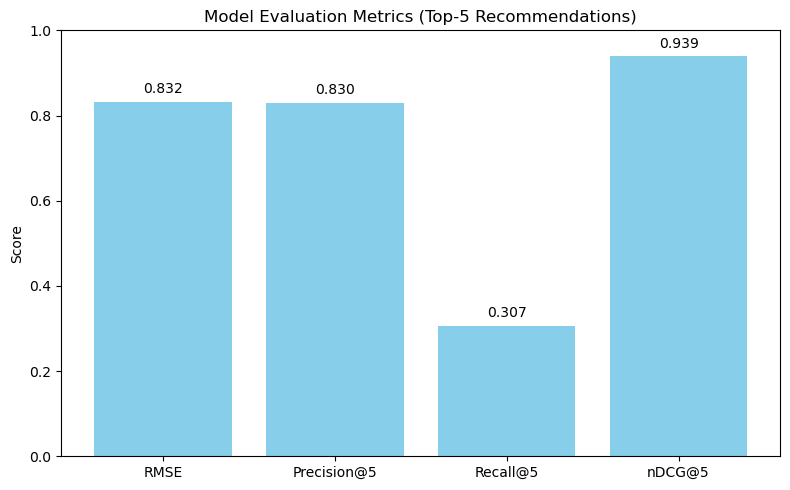

In [6]:
metrics = {
    "RMSE": rmse,
    "Precision@5": precision,
    "Recall@5": recall,
    "nDCG@5": ndcg
}

plt.figure(figsize=(8, 5))
plt.bar(metrics.keys(), metrics.values(), color='skyblue')
plt.title("Model Evaluation Metrics (Top-5 Recommendations)")
plt.ylabel("Score")
plt.ylim(0, 1)
for i, (k, v) in enumerate(metrics.items()):
    plt.text(i, v + 0.02, f"{v:.3f}", ha='center')
plt.tight_layout()
plt.show()

**Zelle 7: Metriken bei Top-N-Empfehlungen (N = 1 bis 20)**

Diese Zelle berechnet und plottet:

- Precision
- Recall
- nDCG
- RMSE

... für jeweils N = 1 bis 20 empfohlene Items.

Ziel: Zu sehen, wie sich die Empfehlungsgüte bei unterschiedlichen Empfehlungsmengen verändert.

51sek Ausführzeit

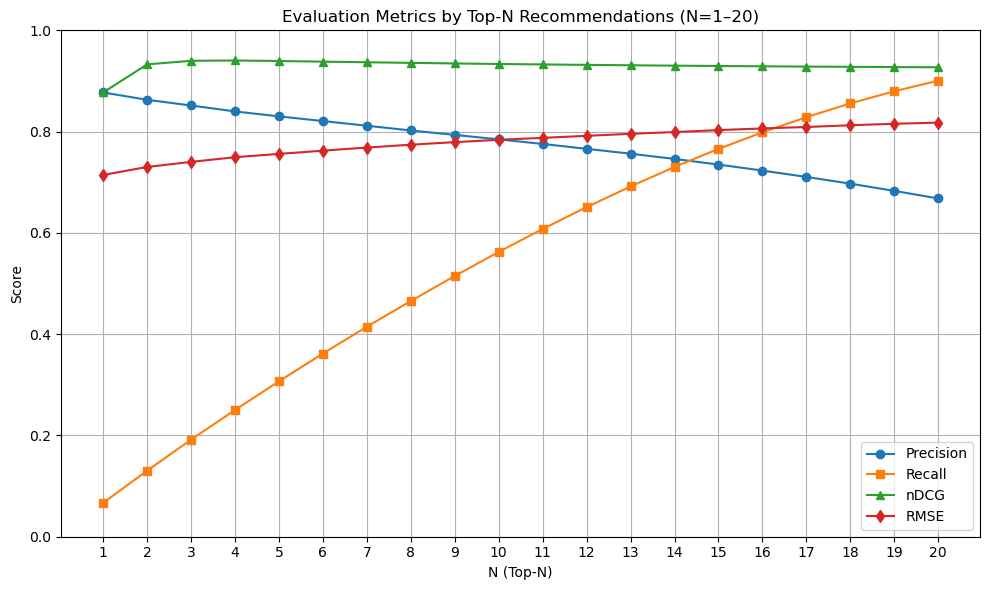

In [7]:
precisions, recalls, ndcgs, rmses = [], [], [], []
N_range = range(1, 21)
top_n_all = get_top_n(predictions, n=20)
prediction_dict = {(p.uid, p.iid): p for p in predictions}

for N in N_range:
    top_n_N = {uid: items[:N] for uid, items in top_n_all.items()}
    p, r, nd = precision_recall_ndcg(top_n_N, ground_truth, N=N)
    precisions.append(p)
    recalls.append(r)
    ndcgs.append(nd)

    top_n_flat = [(uid, iid) for uid, items in top_n_N.items() for (iid, _) in items]
    pred_top_n = [prediction_dict[(uid, iid)] for (uid, iid) in top_n_flat if (uid, iid) in prediction_dict]
    rmse_n = accuracy.rmse(pred_top_n, verbose=False) if pred_top_n else np.nan
    rmses.append(rmse_n)

plt.figure(figsize=(10, 6))
plt.plot(N_range, precisions, marker='o', label='Precision')
plt.plot(N_range, recalls, marker='s', label='Recall')
plt.plot(N_range, ndcgs, marker='^', label='nDCG')
plt.plot(N_range, rmses, marker='d', label='RMSE')
plt.title("Evaluation Metrics by Top-N Recommendations (N=1–20)")
plt.xlabel("N (Top-N)")
plt.ylabel("Score")
plt.xticks(N_range)
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**Zelle 8: Metriken bei verschiedenen `n_factors`**

Diese Zelle:

- trainiert das Modell mit verschiedenen Werten für `n_factors` (Anzahl latenter Faktoren)
- misst für jeden Fall Precision, Recall, nDCG und RMSE
- erstellt einen Plot, um die optimale Modellkomplexität zu identifizieren

Ausführzeit: 6m15sek

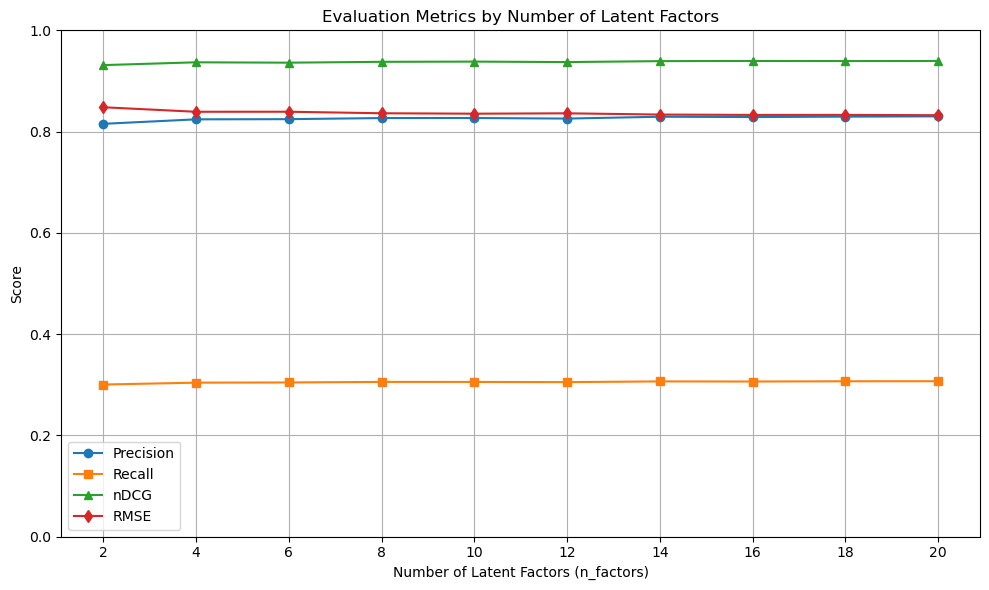

In [8]:
from surprise import SVD

factor_values = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]
precisions, recalls, ndcgs, rmses = [], [], [], []

for nf in factor_values:
    algo = SVD(n_factors=nf, random_state=42)
    algo.fit(trainset)
    predictions = algo.test(testset)

    rmse = accuracy.rmse(predictions, verbose=False)
    top_n = get_top_n(predictions, n=5)
    precision, recall, ndcg = precision_recall_ndcg(top_n, ground_truth, N=5)

    precisions.append(precision)
    recalls.append(recall)
    ndcgs.append(ndcg)
    rmses.append(rmse)

plt.figure(figsize=(10, 6))
plt.plot(factor_values, precisions, marker='o', label='Precision')
plt.plot(factor_values, recalls, marker='s', label='Recall')
plt.plot(factor_values, ndcgs, marker='^', label='nDCG')
plt.plot(factor_values, rmses, marker='d', label='RMSE')
plt.title("Evaluation Metrics by Number of Latent Factors")
plt.xlabel("Number of Latent Factors (n_factors)")
plt.ylabel("Score")
plt.xticks(factor_values)
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
